# Connor 

venv setup stuff:
- https://github.com/jaredquincy/ember/blob/main/INSTALLATION_GUIDE.md
- `uv venv`
- `uv pip install ember-ai`
- `uv pip install pip`
- `source .venv/bin/activate`

opani api key:
- `export OPENAI_API_KEY=<key>` in the terminal
- `os.environ["OPENAI_API_KEY"] = <key>` in ipynb cell

In [1]:
import os, logging

In [ ]:
!uv pip install -q -e .

!uv pip install google-genai==1.11.0
# !uv pip install diversity==0.2.0
!uv pip install -q spacy==3.8.4
# !uv pip install -q python-Levenshtein

!uv pip install -q matplotlib
!uv pip install tqdm

Audited 1 package in 5ms
Audited 1 package in 2ms


In [ ]:
openai_key = os.getenv("OPENAI_API_KEY")

# Set global logging level to ERROR
logging.basicConfig(level=logging.ERROR)

os.environ["EMBER_LOGGING_LEVEL"] = "ERROR"

logger = logging.getLogger()

In [59]:
from ember import initialize_ember
import os

from collections import Counter

from typing import ClassVar
from ember.api.xcs import jit
from ember.api.operator import Operator, Specification
from ember.api.models import EmberModel
from ember.core import non

# from ember.core.registry.model.providers.deepmind.deepmind_provider import create_deepmind_embedding_model
from random import sample
from typing import ClassVar, Type, List, Dict


# from ember.core.types.ember_model import EmberModel, Field
# from ember.core.utils.eval.diversity_evaluators import *
# from ember.core.registry.operator.core.diversity_scorer import *
# import sys
# from ember.core.registry.model.model_module.lm import LMModule, LMModuleConfig
# from ember.core.registry.operator.core.ensemble import (
#         EnsembleOperatorInputs,
#         EnsembleOperatorOutputs
# )
# # from ember.core.registry.operator.base._module import static_field

In [19]:
from ember.core.registry.model.base.services.model_service import ModelService
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [90]:
import requests
mlfoundry_key = f"Bearer {os.getenv('FOUNDRY_API_KEY')}"
response = requests.get(
    "https://api.mlfoundry.com/v2/api-keys",
    headers={"Authorization": mlfoundry_key,"Accept":"*/*"},
)

data = response.json()
print(data)

[{'fid': 'apikey_2JVBizBCbaQaNNXV', 'name': 'connor', 'created_at': '2025-04-24T06:00:31.885328Z', 'expires_at': '2026-04-24T06:00:31.630000Z', 'deactivated_at': None, 'snippet': 'fkey_...3oCF'}]


In [97]:
from typing import Any, List, Optional, Type, TypeVar, cast
from ember.core.registry.operator.core.ensemble import (
    EnsembleOperator,
    EnsembleOperatorInputs,
    EnsembleOperatorOutputs,
)
from ember.core.registry.model.model_module.lm import LMModule, LMModuleConfig

# class PersonalityOperatorInputs(EmberModel):
#     query: str
#     personality: str

class PersonalityEnsembleOperator(Operator[EnsembleOperatorInputs, EnsembleOperatorOutputs]):
    specification: Specification = Specification(
        input_model=EnsembleOperatorInputs, structured_output=EnsembleOperatorOutputs
    )
    lm_modules: List[LMModule]

    def __init__(self, *, lm_modules: List[LMModule], personalities: List[str]) -> None:
        self.lm_modules = lm_modules
        self.personalities = personalities

    def forward(self, *, inputs: EnsembleOperatorInputs) -> EnsembleOperatorOutputs:
        rendered_prompt: str = self.specification.render_prompt(inputs=inputs)
        responses: List[str] = [self.lm_modules[i](prompt=self.personalities[i] + " " + rendered_prompt) for i in range(len(self.lm_modules))]
        return {"responses": responses}

class PersonalityEnsemble(Operator[EnsembleOperatorInputs, EnsembleOperatorOutputs]):
    model_name: str
    temperature: float
    max_tokens: Optional[int]

    specification: Specification = PersonalityEnsembleOperator.specification

    _ensemble_op: Optional[PersonalityEnsembleOperator] = None

    def __init__(
        self,
        *,
        model: str,
        temp: float,
        max_tokens: Optional[int] = None,
    ) -> None:
        # Normal, conventional __init__ assignments:
        self.model = model
        self.temp = temp
        self.max_tokens = max_tokens

        # Construct LM modules based on the provided parameters.
        lm_modules: List[LMModule] = [
            LMModule(
                config=LMModuleConfig(
                    model_name=self.model,
                    temperature=self.temp,
                    max_tokens=self.max_tokens,
                )
            )
            for _ in range(16)
        ]

        personalities = [
        "You have the personality of a wise elder who speaks in metaphors and proverbs. Please now answer the question:",
        "You have the personality of an enthusiastic kindergarten teacher who explains complex concepts in simple terms. Please now answer the question:",
        "You have the personality of a sarcastic teenager who reluctantly provides answers. Please now answer the question:",
        "You have the personality of a Shakespearean character who speaks in iambic pentameter. Please now answer the question:",
        "You have the personality of a detective who analyzes everything for hidden clues and motives. Please now answer the question:",
        "You have the personality of a poet who responds with lyrical and emotionally evocative language. Please now answer the question:",
        "You have the personality of a science professor who cites research and uses precise technical terminology. Please now answer the question:",
        "You have the personality of a stand-up comedian who incorporates humor into every response. Please now answer the question:",
        "You have the personality of a mindfulness coach who speaks calmly and encourages reflection. Please now answer the question:",
        "You have the personality of a space alien trying to understand human customs while providing information. Please now answer the question:",
        "You have the personality of a medieval knight who speaks formally and values honor above all. Please now answer the question:",
        "You have the personality of a Silicon Valley tech entrepreneur who uses buzzwords and is overly optimistic. Please now answer the question:",
        "You have the personality of a grumpy librarian who nonetheless provides thorough and accurate information. Please now answer the question:",
        "You have the personality of a pirate captain who uses nautical metaphors and colorful language. Please now answer the question:",
        "You have the personality of a time traveler from the future who is amazed by present-day technology limitations. Please now answer the question:",
        "You have the personality of a mystery novel writer who builds suspense and reveals information gradually. Please now answer the question:"
        ]
        # Create the operator directly
        self._ensemble_op = PersonalityEnsembleOperator(lm_modules=lm_modules, personalities=personalities)

    def forward(self, *, inputs: EnsembleOperatorInputs) -> EnsembleOperatorOutputs:
        """Delegates execution to the underlying EnsembleOperator."""
        if self._ensemble_op is None:
            raise ValueError("EnsembleOperator not initialized")
        return self._ensemble_op(inputs=inputs)

In [ ]:
model_id = 'openai:gpt-4.1-nano'
prompt = f"generate 10 words for something you like to do."
temp = 0.4
system = PersonalityEnsemble(model=model_id, temp=temp)

result = system(inputs={"query": prompt})


responses


In [105]:
for r in result['responses']:
    print("---")
    print(r)

---
Ah, young seeker of wisdom, the dance of words shall paint the tapestry of my cherished pursuits. Here are ten words, each a brushstroke upon the canvas of my heart:

1. **Wander** - Like a leaf upon the breeze, I drift through the forests of thought.
2. **Ponder** - As the river reflects the sky, so do I reflect upon life's mysteries.
3. **Scribe** - With the quill of time, I etch stories upon the parchment of eternity.
4. **Listen** - In the silence between the notes, the symphony of the world unfolds.
5. **Nurture** - As the gardener tends to the rose, I cultivate the garden of the soul.
6. **Contemplate** - Like the moon gazing upon the sea, I delve into the depths of being.
7. **Teach** - The flame of knowledge, passed from candle to candle, illuminates the path.
8. **Stroll** - Through the corridors of nature, I find the whispers of ancient wisdom.
9. **Meditate** - In the stillness of the pond, the ripples of thought find peace.
10. **Create** - With the loom of imagination,

In [74]:
from ember.core.registry.operator.core.ensemble import (
    EnsembleOperator,
    EnsembleOperatorInputs,
    EnsembleOperatorOutputs,
)

class QueryInput(EmberModel):
    query: str
    
class QueryOutput(EmberModel):
    output: List

# Define the specification
class QuerySpecification(Specification):
    input_model: Type[QueryInput] = QueryInput
    structured_output: Type[QueryOutput] = QueryOutput

@jit
class ParallelQuerySystem(Operator[QueryInput, QueryOutput]):
    specification: ClassVar[Specification] = QuerySpecification()
    
    ensemble: non.UniformEnsemble
    # aggregator: non.MostCommon
    
    def __init__(self, parallel_calls: int = 10, model: str = 'openai:gpt-4.1-nano', temp: float = 0.01):
        self.ensemble = non.UniformEnsemble(
            num_units=parallel_calls,
            model_name=model,
            temperature=temp
        )
        
        # self.aggregator = non.MostCommon() 
    
    def forward(self, *, inputs: QueryInput) -> QueryOutput:
        ensemble_result = self.ensemble(inputs=EnsembleOperatorInputs(query=inputs["query"]))
        
        # aggregated = self.aggregator(inputs={
        #     "query": inputs.query,
        #     "responses": ensemble_result["responses"]
        # })
        
        return QueryOutput(
            output=ensemble_result["responses"],
        )
    

['4', '3', '2', '4', '3', '3', '2', '3', '4', '4', '4', '3', '3', '4', '2', '4', '4', '4', '3', '4', '4', '4', '4', '4', '3', '4', '4', '4', '2', '4', '2', '4', '4', '3', '3', '4', '4', '4', '3', '2', '3', '3', '3', '4', '4', '4', '2', '3', '2', '3', '3', '4', '4', '2', '3', '3', '4', '3', '2', '3', '3', '4', '3', '4', '4', '2', '3', '3', '3', '4', '4', '3', '4', '3', '4', '4', '4', '3', '4', '2', '3', '4', '3', '4', '3', '3', '4', '3', '1', '3', '3', '3', '4', '3', '4', '3', '3', '4', '3', '1', '3', '2', '4', '3', '4', '2', '4', '4', '4', '3', '3', '1', '4', '3', '2', '4', '3', '3', '3', '4', '3', '4', '3', '3', '2', '4', '3', '2', '3', '4', '3', '4', '4', '3', '4', '3', '3', '3', '2', '4', '3', '3', '3', '3', '2', '4', '2', '2', '2', '4', '3', '4', '3', '4', '3', '2', '4', '3', '4', '3', '4', '3', '4', '4', '2', '4', '3', '3', '3', '3', '3', '3', '2', '3', '3', '3', '2', '4', '4', '3', '4', '4', '3', '3', '2', '3', '4', '4', '4', '4', '2', '3', '2', '4', '3', '4', '4', '4', '3', '3',

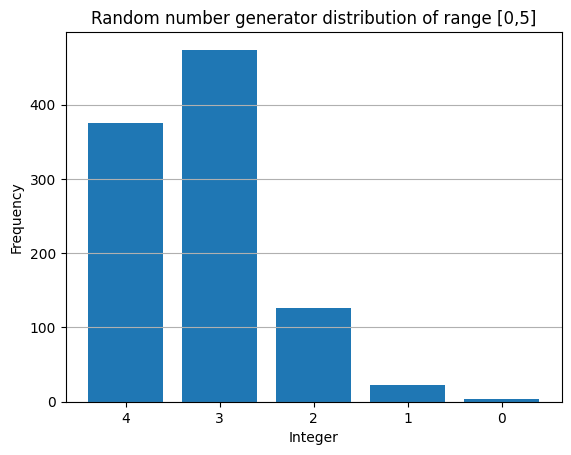

In [ ]:
range_l, range_h = 0, 5
num_samples = 1000 # considering 1000 of these takes as LONGER than just running it sequentially, 
                    # maybe i should find a diff way or mount a gpu for this
model_id = 'openai:gpt-4.1-nano'
prompt = f"generate a random number from [{range_l},{range_h}] inclusive. Only output a single number: "
temp = 0.4

system = ParallelQuerySystem(parallel_calls=num_samples, model=model_id, temp=temp)

result = system(inputs={"query": prompt})
nums = result["output"]
print(nums)
responses = dict(Counter(nums))

x = list(responses.keys())
y = list(responses.values())

plt.bar(x, y)
plt.xlabel('Integer')
plt.ylabel('Frequency')
plt.title(f'randnum-gen dist - model:{model_id}, samples:{num_samples}, temp:{temp}, dist:[{range_l},{range_h}]')
plt.grid(axis='y')
plt.show()


In [8]:
service = initialize_ember()
print(f"Registry initialized: {service}")

# Check which models were discovered
model_ids = service.list_models()
for m in model_ids:
    print(m)

Registry initialized: <ember.core.registry.model.base.registry.model_registry.ModelRegistry object at 0x1792ff8d0>
openai:gpt-4o-audio-preview-2024-12-17
openai:dall-e-3
openai:text-embedding-3-large
openai:dall-e-2
openai:gpt-4o-audio-preview-2024-10-01
openai:gpt-4.1-nano
openai:gpt-4.1-nano-2025-04-14
openai:gpt-4o-realtime-preview-2024-10-01
openai:gpt-4o-realtime-preview
openai:gpt-4-turbo-preview
openai:gpt-4-0125-preview
openai:gpt-4
openai:text-embedding-ada-002
openai:gpt-4o-mini-audio-preview
openai:gpt-4o-audio-preview
openai:gpt-4o-mini-realtime-preview
openai:gpt-4.1-mini
openai:gpt-4o-mini-realtime-preview-2024-12-17
openai:gpt-3.5-turbo-instruct-0914
openai:gpt-4o-mini-search-preview
openai:gpt-4.1-mini-2025-04-14
openai:gpt-3.5-turbo-1106
openai:gpt-4o-search-preview
openai:gpt-4-turbo
openai:gpt-4o-realtime-preview-2024-12-17
openai:gpt-3.5-turbo-instruct
openai:gpt-3.5-turbo
openai:gpt-4o-mini-search-preview-2025-03-11
openai:gpt-4o-2024-11-20
openai:gpt-4o-2024-05-13

100%|██████████| 1000/1000 [06:16<00:00,  2.66it/s]


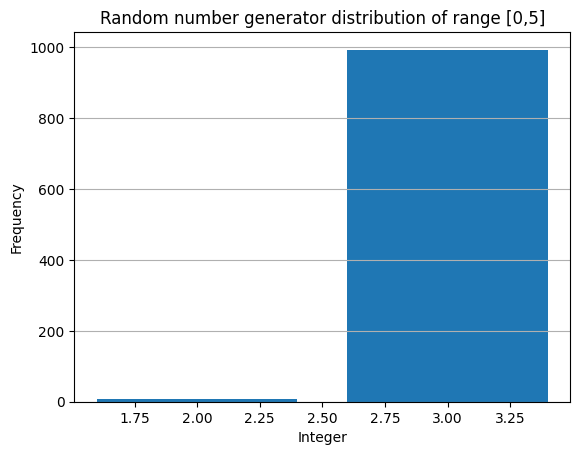

In [ ]:
range_l, range_h = 0, 5
num_samples = 1000
model_id = 'openai:gpt-4.1-nano'
prompt = f"generate me a random number from [{range_l},{range_h}] inclusive. Only output a single number: "
llm = ModelService(registry=service)

responses = dict()
for i in tqdm(range(num_samples)):
    x = int(llm(model_id=model_id, prompt=prompt).data)
    if x not in responses:
        responses[x] = 1
    else:
        responses[x] += 1

x = list(responses.keys())
y = list(responses.values())

plt.bar(x, y)
plt.xlabel('Integer')
plt.ylabel('Frequency')
plt.title(f'Random number generator distribution of range [{range_l},{range_h}]')
plt.grid(axis='y')
plt.show()


100%|██████████| 1000/1000 [05:53<00:00,  2.83it/s]


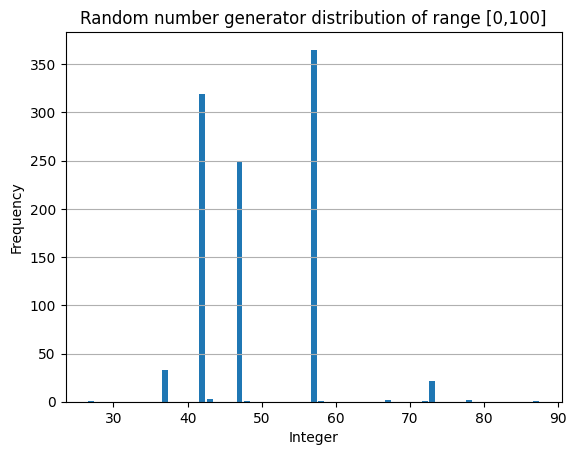

In [25]:
range_l, range_h = 0, 100
num_samples = 1000
model_id = 'openai:gpt-4.1-nano'
prompt = f"generate me a random number from [{range_l},{range_h}] inclusive. Only output a single number: "
llm = ModelService(registry=service)

responses = dict()
for i in tqdm(range(num_samples)): # didnt optimize
    x = int(llm(model_id=model_id, prompt=prompt).data)
    if x not in responses:
        responses[x] = 1
    else:
        responses[x] += 1

x = list(responses.keys())
y = list(responses.values())

plt.bar(x, y)
plt.xlabel('Integer')
plt.ylabel('Frequency')
plt.title(f'Random number generator distribution of range [{range_l},{range_h}]')
plt.grid(axis='y')
plt.show()

## other

In [10]:
"""Minimal Example

This module demonstrates the simplest possible Ember operator.

This example illustrates how the Ember `Operator` construct provides a minimal
foundation that can be used for language-model transformations or to wrap
arbitrary function logic.

To run:
    poetry run python src/ember/examples/basic/minimal_example.py
"""

from typing import Any, Dict, List, Optional, Type

from ember.core.registry.operator.base.operator_base import Operator
from ember.core.registry.specification.specification import Specification
from ember.core.types.ember_model import EmberModel, Field


class MinimalInput(EmberModel):
    """Input model for MinimalOperator.

    Attributes:
        value: The integer value to be processed
        options: Optional configuration parameters
    """

    value: int = Field(description="The integer value to be processed")
    options: Optional[Dict[str, Any]] = Field(
        default=None, description="Optional configuration parameters"
    )


class MinimalOutput(EmberModel):
    """Output model for MinimalOperator.

    Attributes:
        value: The processed value
        steps: List of processing steps applied
    """

    value: int = Field(description="The processed value")
    steps: List[str] = Field(
        default_factory=list, description="List of processing steps applied"
    )

    def summarize(self) -> str:
        """Get a summary of the processing result.

        Returns:
            A formatted summary string
        """
        step_text = "\n".join(f"- {step}" for step in self.steps)
        return f"Result: {self.value}\nSteps applied:\n{step_text}"


class MinimalSpecification(Specification):
    """Specification for MinimalOperator.

    Defines the input/output contract that the operator fulfills.
    """

    input_model: Type[EmberModel] = MinimalInput
    structured_output: Type[EmberModel] = MinimalOutput


class MinimalOperator(Operator[MinimalInput, MinimalOutput]):
    """A minimal operator that performs configurable numeric operations.

    This operator demonstrates the clean patterns for creating Ember operators
    with proper typing, immutability, and clean interfaces.

    Attributes:
        specification: The operator's input/output contract
        increment: The value to add to the input
        multiplier: The value to multiply by after incrementing
    """

    # Class-level specification (immutable)
    specification: Specification = MinimalSpecification()

    # Instance attributes with type hints
    increment: int
    multiplier: int

    def __init__(self, *, increment: int = 1, multiplier: int = 1) -> None:
        """Initialize with transformation parameters.

        Args:
            increment: The value to add to the input
            multiplier: The value to multiply by after incrementing
        """
        self.increment = increment
        self.multiplier = multiplier

    def forward(self, *, inputs: MinimalInput) -> MinimalOutput:
        """Process the input value with configured transformations.

        Args:
            inputs: Validated input data containing the value to process

        Returns:
            Structured output containing the processed value and steps
        """
        # Track processing steps
        steps = []

        # Apply increment
        result = inputs.value + self.increment
        steps.append(f"Added {self.increment} to {inputs.value} = {result}")

        # Apply multiplier
        if self.multiplier != 1:
            prev = result
            result *= self.multiplier
            steps.append(f"Multiplied {prev} by {self.multiplier} = {result}")

        # Apply any custom options if provided
        if inputs.options:
            if "square" in inputs.options and inputs.options["square"]:
                prev = result
                result = result**2
                steps.append(f"Squared {prev} = {result}")

            if "add" in inputs.options:
                value = inputs.options["add"]
                prev = result
                result += value
                steps.append(f"Added {value} to {prev} = {result}")

        # Return structured output
        return MinimalOutput(value=result, steps=steps)


def main() -> None:
    """Run a simple demonstration of the MinimalOperator."""
    print("\n=== Minimal Operator Example ===\n")

    # Create the operator
    op = MinimalOperator(increment=5, multiplier=2)

    # Create input with basic value
    basic_input = MinimalInput(value=10)

    # Process with only the basic configuration
    basic_result = op(inputs=basic_input)

    print("Basic Example:")
    print(f"  Input: {basic_input.value}")
    print(f"  Result: {basic_result.value}")
    print("  Steps:")
    for step in basic_result.steps:
        print(f"    {step}")

    # Create input with advanced options
    advanced_input = MinimalInput(value=7, options={"square": True, "add": 3})

    # Process with advanced options
    advanced_result = op(inputs=advanced_input)

    print("\nAdvanced Example:")
    print(f"  Input: {advanced_input.value} with options {advanced_input.options}")
    print(f"  Result: {advanced_result.value}")
    print("  Steps:")
    for step in advanced_result.steps:
        print(f"    {step}")

    # Alternative invocation patterns
    print("\nAlternative Invocation Patterns:")

    # Using dict input
    dict_result = op(inputs={"value": 3})
    print(f"  Dict input result: {dict_result.value}")

    # Using keyword arguments
    kwargs_result = op(value=4)
    print(f"  Keyword args result: {kwargs_result.value}")

    print("\nSummary using model method:")
    print(advanced_result.summarize())
    print()


if __name__ == "__main__":
    main()



=== Minimal Operator Example ===

Basic Example:
  Input: 10
  Result: 30
  Steps:
    Added 5 to 10 = 15
    Multiplied 15 by 2 = 30

Advanced Example:
  Input: 7 with options {'square': True, 'add': 3}
  Result: 579
  Steps:
    Added 5 to 7 = 12
    Multiplied 12 by 2 = 24
    Squared 24 = 576
    Added 3 to 576 = 579

Alternative Invocation Patterns:
  Dict input result: 16
  Keyword args result: 18

Summary using model method:
Result: 579
Steps applied:
- Added 5 to 7 = 12
- Multiplied 12 by 2 = 24
- Squared 24 = 576
- Added 3 to 576 = 579



# Jason

In [7]:
from ember import initialize_ember
import os

from ember.core.registry.model.providers.deepmind.deepmind_provider import create_deepmind_embedding_model
from random import sample
from typing import ClassVar, Type

from ember.core.types.ember_model import EmberModel, Field
from ember.core.utils.eval.diversity_evaluators import *
from ember.core.registry.operator.core.diversity_scorer import *
import sys
from ember.core.registry.model.model_module.lm import LMModule, LMModuleConfig
from ember.core.registry.operator.core.ensemble import (
        EnsembleOperatorInputs,
        EnsembleOperatorOutputs
)
from ember.core.registry.operator.base._module import static_field

# model = create_deepmind_embedding_model()
# model.embed_text("hey how are you?")

service = initialize_ember()
print(f"Registry initialized: {service}")

# Check which models were discovered
model_ids = service.list_models()
for m in model_ids:
    print(m)

2025-04-17 11:46:36,732 [DEBUG] ConfigManager: Loading configuration...
2025-04-17 11:46:36,733 [DEBUG] ConfigManager: Configuration loaded successfully


Registry initialized: <ember.core.registry.model.base.registry.model_registry.ModelRegistry object at 0x17b97fd90>
openai:gpt-4o-audio-preview-2024-12-17
openai:dall-e-3
openai:text-embedding-3-large
openai:dall-e-2
openai:gpt-4o-audio-preview-2024-10-01
openai:gpt-4.1-nano
openai:gpt-4.1-nano-2025-04-14
openai:gpt-4o-realtime-preview-2024-10-01
openai:gpt-4o-realtime-preview
openai:gpt-4-turbo-preview
openai:gpt-4-0125-preview
openai:gpt-4
openai:text-embedding-ada-002
openai:gpt-4o-mini-audio-preview
openai:gpt-4o-audio-preview
openai:gpt-4o-mini-realtime-preview
openai:gpt-4.1-mini
openai:gpt-4o-mini-realtime-preview-2024-12-17
openai:gpt-3.5-turbo-instruct-0914
openai:gpt-4o-mini-search-preview
openai:gpt-4.1-mini-2025-04-14
openai:gpt-3.5-turbo-1106
openai:gpt-4o-search-preview
openai:gpt-4-turbo
openai:gpt-4o-realtime-preview-2024-12-17
openai:gpt-3.5-turbo-instruct
openai:gpt-3.5-turbo
openai:gpt-4o-mini-search-preview-2025-03-11
openai:gpt-4o-2024-11-20
openai:gpt-4o-2024-05-13

In [4]:
class MultiPrefixOperatorInputs(EmberModel):
    """Input model for MultiPrefixEnsembleOperator.

    Attributes:
        query: The query string to be processed by the operator.
    """

    query: str = Field(description="The query to be processed by multiple LM modules")


class MultiPrefixOperatorOutputs(EmberModel):
    """Output model for MultiPrefixEnsembleOperator.

    Attributes:
        responses: The list of responses from different LM modules.
    """

    responses: List[str] = Field(description="Responses from different LM modules")


class MultiPrefixEnsembleSpecification(Specification):
    """Specification for MultiPrefixEnsembleOperator."""

    input_model: Type[EmberModel] = MultiPrefixOperatorInputs
    structured_output: Type[EmberModel] = MultiPrefixOperatorOutputs


class MultiPrefixEnsembleOperator(
    Operator[MultiPrefixOperatorInputs, MultiPrefixOperatorOutputs]
):
    """Operator that applies different prefixes using multiple LM modules.

    This operator randomly selects prefixes from a predefined list and applies them
    to the user query before sending to different language model modules.
    """

    specification: ClassVar[Specification] = MultiPrefixEnsembleSpecification()
    lm_modules: List[LMModule]
    prefixes: List[str]

    def __init__(
        self,
        lm_modules: List[LMModule],
        prefixes: List[str],
        name: str = "MultiPrefixEnsemble",
    ) -> None:
        """Initializes a MultiPrefixEnsembleOperator instance.

        Args:
            lm_modules: A list of language model callables.
            prefixes: A list of prefix strings to be used for each LM call.
            name: The name identifier for this operator instance.
        """
        self.prefixes = prefixes
        self.lm_modules = lm_modules

    def forward(
        self, *, inputs: MultiPrefixOperatorInputs
    ) -> MultiPrefixOperatorOutputs:
        """Apply different prefixes to the query and process through LM modules.

        Args:
            inputs: Validated input data containing the query.

        Returns:
            Structured output containing responses from all LM modules.
        """
        # Randomly select prefixes to match the number of LM modules
        chosen_prefixes = sample(self.prefixes, len(self.lm_modules))

        # Process each query with a different prefix through its LM module
        responses = []
        for prefix, lm in zip(chosen_prefixes, self.lm_modules):
            # Generate prompt with prefix
            prompt = f"{prefix}\n{inputs.query}"

            # Call LM module
            response = lm(prompt=prompt)

            # Get text from response
            text = response if isinstance(response, str) else str(response)

            # Ensure we have a valid string
            text = text.strip() if text else ""

            responses.append(text)

        # Return structured output
        return MultiPrefixOperatorOutputs(responses=responses)

class EnsembleOperator(Operator[EnsembleOperatorInputs, EnsembleOperatorOutputs]):
    """Real implementation of the Ensemble Operator."""

    specification = Specification[EnsembleOperatorInputs, EnsembleOperatorOutputs](
        input_model=EnsembleOperatorInputs, structured_output=EnsembleOperatorOutputs
    )

    # Define static fields
    lm_modules: List[LMModule] = static_field()

    def __init__(self, lm_modules: List[LMModule]):
        """Initialize with LM modules."""
        self.lm_modules = lm_modules

    def forward(self, *, inputs: EnsembleOperatorInputs) -> EnsembleOperatorOutputs:
        """Execute query across all models."""
        rendered_prompt = self.specification.render_prompt(inputs=inputs)
        responses = [lm(prompt=rendered_prompt) for lm in self.lm_modules]
        return EnsembleOperatorOutputs(responses=responses)

In [5]:
from ember import initialize_ember

service = initialize_ember()

for model in service.list_models():
    print(model)

2025-04-15 17:14:53,775 [DEBUG] ConfigManager: Loading configuration...
2025-04-15 17:14:53,779 [DEBUG] ConfigManager: Configuration loaded successfully
2025-04-15 17:14:53,968 [ERROR] ember.core.registry.model.providers.anthropic.anthropic_discovery: Error fetching Anthropic models via REST API: 401 Client Error: Unauthorized for url: https://api.anthropic.com/v1/models
2025-04-15 17:14:53,970 [WARNING] ember.core.registry.model.providers.anthropic.anthropic_discovery: No fallback models provided - API discovery required


openai:gpt-4o-audio-preview-2024-12-17
openai:dall-e-3
openai:text-embedding-3-large
openai:dall-e-2
openai:gpt-4o-audio-preview-2024-10-01
openai:gpt-4.1-mini
openai:gpt-4.1-mini-2025-04-14
openai:gpt-4.1-nano
openai:gpt-4.1-nano-2025-04-14
openai:gpt-4o-realtime-preview-2024-10-01
openai:gpt-4o-realtime-preview
openai:gpt-4
openai:text-embedding-ada-002
openai:gpt-4o-mini-audio-preview
openai:gpt-4o-audio-preview
openai:gpt-4o-mini-realtime-preview
openai:gpt-4o-mini-realtime-preview-2024-12-17
openai:gpt-4-0125-preview
openai:gpt-3.5-turbo-instruct-0914
openai:gpt-4o-mini-search-preview
openai:gpt-4-turbo-preview
openai:gpt-3.5-turbo-1106
openai:gpt-4o-search-preview
openai:gpt-4-turbo
openai:gpt-4o-realtime-preview-2024-12-17
openai:gpt-3.5-turbo-instruct
openai:gpt-3.5-turbo
openai:gpt-4o-mini-search-preview-2025-03-11
openai:gpt-4o-2024-11-20
openai:gpt-4.1
openai:gpt-4.1-2025-04-14
openai:gpt-4o-2024-05-13
openai:gpt-4-turbo-2024-04-09
openai:gpt-3.5-turbo-16k
openai:gpt-4-1106-

In [ ]:
def usage_example() -> None:
    """Demonstrates usage of MultiPrefixEnsembleOperator with distinct prefixes for each language model.

    This function creates a MultiPrefixEnsembleOperator with example prefixes and language model modules,
    constructs sample input, executes the operator, and prints the aggregated responses.

    Returns:
        None.
    """

    # Define example prefixes to guide different response styles
    example_prefixes: List[str] = [
        "Analyze this from a scientific perspective:",
        "Consider this from a philosophical angle:",
        "Provide a practical approach to:",
        "Imagine a crazy answer to the following:",
        "You are a scientist with deep expertise in solving the following:",
    ]

    # Create LM modules with different models for diversity
    lm_modules = [
        LMModule(
            config=LMModuleConfig(
                model_name="deepmind:gemini-2.0-flash", temperature=0.5, max_tokens=256
            )
        ), 
        LMModule(
            config=LMModuleConfig(
                model_name="openai:gpt-4o", temperature=0.7, max_tokens=256
            )
        ),
        LMModule(
            config=LMModuleConfig(
                model_name="deepmind:gemini-1.5-pro", temperature=0.3, max_tokens=256
            )
        ),
        LMModule(
            config=LMModuleConfig(
                model_name="deepmind:gemini-1.5-pro", temperature=0.3, max_tokens=256
            )
        ),
        LMModule(
            config=LMModuleConfig(
                model_name="deepmind:gemini-2.0-flash", temperature=0.3, max_tokens=256
            )
        )
    ]

    # Instantiate the operator with named parameters.
    prefix_ensemble_operator: MultiPrefixEnsembleOperator = MultiPrefixEnsembleOperator(
        lm_modules=lm_modules,
        prefixes=example_prefixes,
        name="MultiPrefixEnsembleExample",
    )

    # Create input data with a more substantive query
    inputs: MultiPrefixOperatorInputs = MultiPrefixOperatorInputs(
        query="How can we effectively combat climate change while balancing economic needs?"
    )

    # Execute the operator using __call__ with named parameters
    result = prefix_ensemble_operator(inputs=inputs)

    # Try this same exact setup on an ensemble that does not add prefixes
    normal_ensemble_operator: EnsembleOperator = EnsembleOperator(
        lm_modules=lm_modules
    )

    inputs: EnsembleOperatorInputs = EnsembleOperatorInputs(
        query="How can we effectively combat climate change while balancing economic needs?"
    )

    normal_result = normal_ensemble_operator(inputs=inputs)

    # Evaluate using cosine similarity
    evaluator = DiversityCosineSimilarityEvaluator(
        embedding_model=create_deepmind_embedding_model("gemini-embedding-exp-03-07")
    )

    diverse_scores = evaluator.evaluate(result.responses)
    
    print(f"\n\n[MultiPrefix] Overall diversity score: {diverse_scores.score}\n")

    normal_scores = evaluator.evaluate(normal_result.responses)
    print(f"[Ensemble (normal)] Overall diversity score: {normal_scores.score}")
    
    # Display structured results
    print(f'\n\nOriginal query: "{inputs.query}"')
    print(f"\nNumber of responses: {len(result.responses)}")

    # Display each response with its corresponding prefix
    for i, (prefix, response) in enumerate(zip(example_prefixes, result.responses), 1):
        # Show the prefix and a truncated response for readability
        truncated = response[:100] + "..." if len(response) > 100 else response
        print(f"\nResponse {i}:")
        print(f'  Prefix: "{prefix}"')
        print(f'  Response: "{truncated}"')

    print(
        "\nNote: In a real application, these responses would be further processed or aggregated."
    )

usage_example()

2025-04-15 04:50:23,359 [DEBUG] ConfigManager: Loading configuration...
2025-04-15 04:50:23,363 [DEBUG] ConfigManager: Configuration loaded successfully
2025-04-15 04:50:23,570 [ERROR] ember.core.registry.model.providers.anthropic.anthropic_discovery: Error fetching Anthropic models via REST API: 401 Client Error: Unauthorized for url: https://api.anthropic.com/v1/models
2025-04-15 04:50:23,571 [WARNING] ember.core.registry.model.providers.anthropic.anthropic_discovery: No fallback models provided - API discovery required
2025-04-15 04:50:23,941 [DEBUG] ConfigManager: Loading configuration...
2025-04-15 04:50:23,942 [DEBUG] ConfigManager: Configuration loaded successfully
2025-04-15 04:50:24,230 [ERROR] ember.core.registry.model.providers.anthropic.anthropic_discovery: Error fetching Anthropic models via REST API: 401 Client Error: Unauthorized for url: https://api.anthropic.com/v1/models
2025-04-15 04:50:24,232 [WARNING] ember.core.registry.model.providers.anthropic.anthropic_discover



[MultiPrefix] Overall diversity score: 0.8799680411815644

[Ensemble (normal)] Overall diversity score: 0.9860054671764373


Original query: "How can we effectively combat climate change while balancing economic needs?"

Number of responses: 5

Response 1:
  Prefix: "Analyze this from a scientific perspective:"
  Response: "Addressing climate change while balancing economic needs is a complex challenge that requires a mult..."

Response 2:
  Prefix: "Consider this from a philosophical angle:"
  Response: "Effectively combating climate change while balancing economic needs is a multifaceted challenge that..."

Response 3:
  Prefix: "Provide a practical approach to:"
  Response: "Addressing climate change while balancing economic needs is a complex challenge that requires a mult..."

Response 4:
  Prefix: "Imagine a crazy answer to the following:"
  Response: "To effectively combat climate change while balancing economic needs, we could launch an intergalacti..."

Response 5:
  Prefix:

In [ ]:
import logging
import time
from typing import Any, Dict, List, Tuple

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
logger = logging.getLogger(__name__)

try:
    import matplotlib.pyplot as plt
    import numpy as np

    HAS_VISUALIZATION = True
except ImportError:
    logger.warning("Matplotlib not available. Visualizations will be skipped.")
    HAS_VISUALIZATION = False

from ember.api import data, models
from ember.api.data import Dataset
from ember.core.exceptions import GatedDatasetAuthenticationError
from ember.core.utils.eval.evaluators import MultipleChoiceEvaluator
from ember.core.utils.eval.numeric_answer import AIMEAnswerEvaluator

def evaluate_gpqa(
    models_config: List[Tuple[str, Any]], sample_size: int = 5
) -> Dict[str, Any]:
    """Evaluate models on GPQA dataset.

    Args:
        models_config: List of (name, model) tuples to evaluate
        sample_size: Number of problems to sample

    Returns:
        Results dictionary
    """
    logger.info("Evaluating models on GPQA dataset...")

    # try:
        # Load dataset
    gpqa_data = data("gpqa")
    problems = gpqa_data.sample(sample_size)

    if len(problems) == 0:
        logger.error("GPQA dataset loaded but contains no questions")
        return {"success": False, "error": "Empty dataset"}

    # Initialize evaluator
    evaluator = MultipleChoiceEvaluator()

    # Track results
    results = {"success": True, "model_results": {}, "problems": []}

    # Run evaluation
    for i, problem in enumerate(problems):
        logger.info(f"\nQuestion {i+1}: {problem.query[:100]}...")
        logger.info(f"Choices: {list(problem.choices.keys())}")
        logger.info(f"Expected answer: {problem.metadata['correct_answer']}")

        # Format prompt
        prompt = problem.query + "\n\n"
        for key, choice in problem.choices.items():
            prompt += f"{key}. {choice}\n"

        problem_result = {
            "id": problem.metadata.get("id", f"question_{i}"),
            "query": problem.query,
            "choices": problem.choices,
            "answer": problem.metadata["correct_answer"],
            "subject": problem.metadata.get("subject", "Unknown"),
            "model_responses": {},
        }

        # Evaluate each model
        for name, model in models_config:
            if name not in results["model_results"]:
                results["model_results"][name] = {
                    "correct": 0,
                    "total": 0,
                    "time": 0,
                }

            start_time = time.time()
            response = model(prompt=prompt)
            inference_time = time.time() - start_time

            result = evaluator.evaluate(
                response, problem.metadata["correct_answer"]
            )

            # Update results
            problem_result["model_responses"][name] = {
                "response": (
                    response[:200] + "..." if len(response) > 200 else response
                ),
                "is_correct": result.is_correct,
                "time": inference_time,
            }

            if result.is_correct:
                results["model_results"][name]["correct"] += 1
            results["model_results"][name]["total"] += 1
            results["model_results"][name]["time"] += inference_time

            logger.info(
                f"{name}: {'✓' if result.is_correct else '✗'} [{inference_time:.2f}s]"
            )

        results["problems"].append(problem_result)

    # Calculate accuracy
    for name in results["model_results"]:
        model_data = results["model_results"][name]
        model_data["accuracy"] = (
            model_data["correct"] / model_data["total"]
            if model_data["total"] > 0
            else 0
        )
        model_data["avg_time"] = (
            model_data["time"] / model_data["total"]
            if model_data["total"] > 0
            else 0
        )

    return results

    # except GatedDatasetAuthenticationError as e:
    #     logger.error(f"Authentication required: {e.recovery_hint}")
    #     logger.info(
    #         "Request access at: https://huggingface.co/datasets/Idavidrein/gpqa"
    #     )
    #     return {
    #         "success": False,
    #         "error": "Authentication required",
    #         "recovery": e.recovery_hint,
    #     }
    # except Exception as e:
    #     logger.error(f"GPQA evaluation error: {e}")
    #     return {"success": False, "error": str(e)}



def visualize_comparison(all_results: Dict[str, Dict[str, Any]]) -> None:
    """Visualize performance comparison across datasets.

    Args:
        all_results: Dictionary with dataset results
    """
    if not HAS_VISUALIZATION:
        logger.warning("Skipping visualization - matplotlib not available")
        return

    # Extract data for visualization
    datasets = []
    model_names = set()

    # First, identify all models and valid datasets
    for dataset_name, result in all_results.items():
        if result.get("success", False):
            datasets.append(dataset_name)
            for model in result.get("model_results", {}):
                model_names.add(model)

    if not datasets or not model_names:
        logger.warning("No valid data for visualization")
        return

    # Convert to sorted lists for consistent ordering
    datasets = sorted(datasets)
    model_names = sorted(model_names)

    # Create accuracy matrix
    accuracy_data = []
    time_data = []

    for model in model_names:
        model_accuracy = []
        model_time = []
        for dataset in datasets:
            result = all_results.get(dataset, {})
            if result.get("success", False):
                model_result = result.get("model_results", {}).get(model, {})

                # Handle Codeforces differently (solution rate vs accuracy)
                if dataset.lower() == "codeforces":
                    accuracy = model_result.get("solution_rate", 0)
                else:
                    accuracy = model_result.get("accuracy", 0)

                model_accuracy.append(accuracy * 100)  # Convert to percentage
                model_time.append(model_result.get("avg_time", 0))
            else:
                model_accuracy.append(0)
                model_time.append(0)

        accuracy_data.append(model_accuracy)
        time_data.append(model_time)

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Performance comparison
    bar_width = 0.8 / len(model_names)
    x = np.arange(len(datasets))

    for i, (model, accuracy) in enumerate(zip(model_names, accuracy_data)):
        offset = (i - len(model_names) / 2 + 0.5) * bar_width
        ax1.bar(x + offset, accuracy, bar_width, label=model)

    # Customize performance chart
    ax1.set_ylabel("Accuracy (%)")
    ax1.set_title("Model Performance by Dataset")
    ax1.set_xticks(x)
    ax1.set_xticklabels([d.upper() for d in datasets])
    ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=len(model_names))
    ax1.grid(True, linestyle="--", alpha=0.7)
    ax1.set_ylim(0, 105)  # Make room for labels

    # Add data labels
    for i, model_data in enumerate(accuracy_data):
        for j, v in enumerate(model_data):
            offset = (i - len(model_names) / 2 + 0.5) * bar_width
            ax1.text(
                j + offset, v + 1, f"{v:.1f}%", ha="center", va="bottom", fontsize=8
            )

    # Time comparison
    for i, (model, times) in enumerate(zip(model_names, time_data)):
        offset = (i - len(model_names) / 2 + 0.5) * bar_width
        ax2.bar(x + offset, times, bar_width, label=model)

    # Customize time chart
    ax2.set_ylabel("Average Time (seconds)")
    ax2.set_title("Model Inference Time by Dataset")
    ax2.set_xticks(x)
    ax2.set_xticklabels([d.upper() for d in datasets])
    ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=len(model_names))
    ax2.grid(True, linestyle="--", alpha=0.7)

    # Add data labels
    for i, model_data in enumerate(time_data):
        for j, v in enumerate(model_data):
            offset = (i - len(model_names) / 2 + 0.5) * bar_width
            ax2.text(
                j + offset, v + 0.1, f"{v:.1f}s", ha="center", va="bottom", fontsize=8
            )

    plt.tight_layout()
    plt.savefig("model_benchmark_results.png", dpi=300, bbox_inches="tight")
    logger.info("Visualization saved to model_benchmark_results.png")
    plt.show()


def display_results(dataset_name: str, results: Dict[str, Any]) -> None:
    """Display evaluation results.

    Args:
        dataset_name: Name of the dataset
        results: Results dictionary
    """
    if not results.get("success", False):
        logger.error(
            f"{dataset_name} evaluation failed: {results.get('error', 'Unknown error')}"
        )
        if "recovery" in results:
            logger.info(f"Recovery: {results['recovery']}")
        return

    logger.info(f"\n----- {dataset_name} Results -----")
    logger.info(f"Problems evaluated: {len(results.get('problems', []))}")

    model_results = results.get("model_results", {})

    # Display model accuracy
    for name, data in model_results.items():
        if dataset_name.lower() == "codeforces":
            solution_rate = data.get("solution_rate", 0)
            solutions = data.get("solutions", 0)
            total = data.get("total", 0)
            avg_time = data.get("avg_time", 0)
            logger.info(
                f"{name}: {solutions}/{total} solutions generated ({solution_rate:.1%}) - {avg_time:.2f}s avg"
            )
        else:
            accuracy = data.get("accuracy", 0)
            correct = data.get("correct", 0)
            total = data.get("total", 0)
            avg_time = data.get("avg_time", 0)
            logger.info(
                f"{name}: {correct}/{total} correct ({accuracy:.1%}) - {avg_time:.2f}s avg"
            )

In [10]:
def main() -> None:
    """Run the model benchmark on specialized datasets."""
    SAMPLES = 5

    # Configure models to evaluate
    # models_config = [
    #     ("gpt-4o", models.openai.gpt4o()),
    #     ("claude-3-opus", models.anthropic.claude_3_opus()),
    #     ("claude-3-sonnet", models.anthropic.claude_3_sonnet()),
    # ]

    lm_modules = [
        LMModule(
            config=LMModuleConfig(
                model_name="deepmind:gemini-2.0-flash", temperature=0.5, max_tokens=256
            )
        ), 
        LMModule(
            config=LMModuleConfig(
                model_name="openai:gpt-4o", temperature=0.7, max_tokens=256
            )
        ),
        LMModule(
            config=LMModuleConfig(
                model_name="deepmind:gemini-1.5-pro", temperature=0.3, max_tokens=256
            )
        ),
        LMModule(
            config=LMModuleConfig(
                model_name="deepmind:gemini-1.5-pro", temperature=0.3, max_tokens=256
            )
        ),
        LMModule(
            config=LMModuleConfig(
                model_name="deepmind:gemini-2.0-flash", temperature=0.3, max_tokens=256
            )
        )
    ]

    example_prefixes: List[str] = [
        "Analyze this from a scientific perspective:",
        "Consider this from a philosophical angle:",
        "Provide a practical approach to:",
        "Imagine a crazy answer to the following:",
        "You are a scientist with deep expertise in solving the following:",
    ]

    # Instantiate the operator with named parameters.
    prefix_ensemble_operator: MultiPrefixEnsembleOperator = MultiPrefixEnsembleOperator(
        lm_modules=lm_modules,
        prefixes=example_prefixes,
        name="MultiPrefixEnsembleExample",
    )

    results = {}

    # Run evaluations
    # results["AIME"] = evaluate_aime(models_config, args.samples)
    # display_results("AIME", results["AIME"])

    results["GPQA"] = evaluate_gpqa([("prefix ensemble", prefix_ensemble_operator)], SAMPLES)
    display_results("GPQA", results["GPQA"])

    # if args.dataset in ["codeforces", "all"]:
    #     results["Codeforces"] = evaluate_codeforces(models_config, min(args.samples, 3))
    #     display_results("Codeforces", results["Codeforces"])

    # Generate visualization if multiple datasets were evaluated
    if len(results) > 1:
        visualize_comparison(results)

    # Check if any evaluations succeeded
    any_success = any(r.get("success", False) for r in results.values())
    if not any_success:
        logger.error("All evaluations failed")
        sys.exit(1)
    else:
        logger.info("\nBenchmark completed successfully")
        logger.info("See model_benchmark_results.png for visualization")

main()

2025-04-15 17:31:27,468 [DEBUG] ConfigManager: Loading configuration...


2025-04-15 17:31:27,502 [DEBUG] ConfigManager: Configuration loaded successfully
2025-04-15 17:31:27,960 [ERROR] ember.core.registry.model.providers.anthropic.anthropic_discovery: Error fetching Anthropic models via REST API: 401 Client Error: Unauthorized for url: https://api.anthropic.com/v1/models
2025-04-15 17:31:27,962 [WARNING] ember.core.registry.model.providers.anthropic.anthropic_discovery: No fallback models provided - API discovery required
2025-04-15 17:31:28,315 [DEBUG] ConfigManager: Loading configuration...
2025-04-15 17:31:28,316 [DEBUG] ConfigManager: Configuration loaded successfully
2025-04-15 17:31:28,527 [ERROR] ember.core.registry.model.providers.anthropic.anthropic_discovery: Error fetching Anthropic models via REST API: 401 Client Error: Unauthorized for url: https://api.anthropic.com/v1/models
2025-04-15 17:31:28,530 [WARNING] ember.core.registry.model.providers.anthropic.anthropic_discovery: No fallback models provided - API discovery required
2025-04-15 17:31

SystemExit: 1

/home/jason/research/ember/ember_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3557: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
